In [1]:
from xml.etree import ElementTree
import glob
from skimage.io import imread
from skimage import draw, morphology, transform, util
import numpy as np
from tensorflow import keras
import tensorflow as tf
import typing
from skimage.io import imshow
from matplotlib import pyplot
import model_arch
import data_augment
WIDTH = 100
HEIGHT = 600
tf.keras.backend.set_image_data_format('channels_last')

2023-06-14 09:46:11.025627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_annotations(filename) -> ElementTree.ElementTree:
    et = ElementTree.parse(filename)
    return et

def get_image_names(folder_pattern) -> typing.List[str]:
    image_names = sorted(glob.glob(folder_pattern))
    return image_names

def extract_points(polyline):
    pstr = polyline.attrib['points']
    pairs = pstr.split(';')
    points = []
    for pair in pairs:
        xstr, ystr = pair.split(',')
        x = float(xstr)
        y = float(ystr)
        points.append((x,y))
    return points

def extract_polylines(image_elem):
    polyline_elems = image_elem.findall('polyline')
    polylines = []
    for elem in polyline_elems:
        points = extract_points(elem)
        polylines.append(points)
    return polylines

def extract_all_paths(annotation):
    paths = {}
    image_elems = annotation.findall("image")
    for element in image_elems:
        name = element.attrib['name']
        polylines = extract_polylines(element)
        paths[name] = polylines
    return paths

def create_mask(polylines):
    blank = np.zeros((HEIGHT, WIDTH), dtype=bool)
    for pline in polylines:
        for i in range(len(pline) - 1):
            start_x, start_y = pline[i]
            end_x, end_y = pline[i + 1]
            # enforcing bounds
            start_x = round(min(max(0, start_x), WIDTH - 1))
            start_y = round(min(max(0, start_y), HEIGHT - 1))
            end_x = round(min(max(0, end_x), WIDTH - 1))
            end_y = round(min(max(0, end_y), HEIGHT - 1))
            # bounds have been enforced
            line = draw.line(start_y, start_x, end_y, end_x)
            blank[line] = True
    # improves visual strength and better perceptual representation
    blank = morphology.dilation(blank)
    return blank

def organize_data(image_names, proboscis_coords):
    input_images = []
    output_images = []
    for name in image_names:
        img = imread(name)
        input_images.append(img)
        plines = proboscis_coords[name]
        mask = create_mask(plines)
        output_images.append(mask)
    input_data = np.array(input_images)
    input_data = input_data[..., np.newaxis]
    output_data = np.array(output_images)
    output_data = output_data[..., np.newaxis]
    return input_data, output_data

In [3]:
annotations = get_annotations("trainInPlabels_annotations.xml")
proboscis_labels_coord = extract_all_paths(annotations)
image_names = get_image_names("trainInP/*")
indata, outdata = organize_data(image_names, proboscis_labels_coord)
imseq = data_augment.ImageSeq(indata, outdata, batch=16)
rep = data_augment.RepeatSeq(imseq, 16)
#rf = data_augment.RandomFlip(rep)
shift1 = data_augment.RandomXShift(rep)
augmented = data_augment.RandomYShift(shift1)

In [4]:
model = keras.models.load_model("proboscis_model_b1")

2023-06-14 09:46:46.428173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-14 09:46:46.449880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-14 09:46:46.450020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
imseq = data_augment.ImageSeq(indata, outdata, batch=16)
rep = data_augment.RepeatSeq(imseq, 16)
#rf = data_augment.RandomFlip(rep)
shift1 = data_augment.RandomXShift(rep)
augmented = data_augment.RandomYShift(shift1)

In [6]:
len(augmented)

864

In [67]:
h = augmented[300]

In [68]:
h_in, h_out = h

In [69]:
h_in.shape

(16, 600, 100, 1)

In [70]:
pred = model(h_in).numpy()

/tmp/ipykernel_15580/3066885849.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


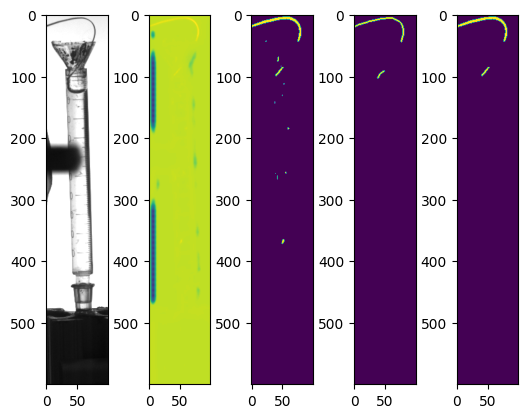

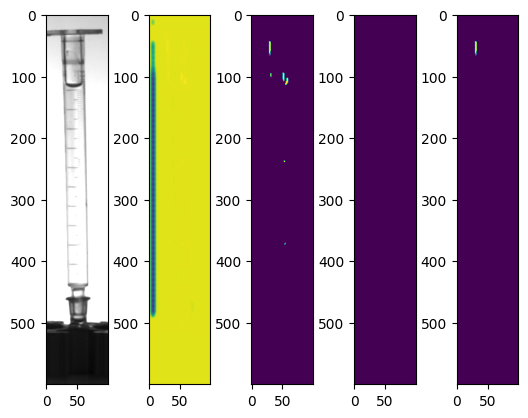

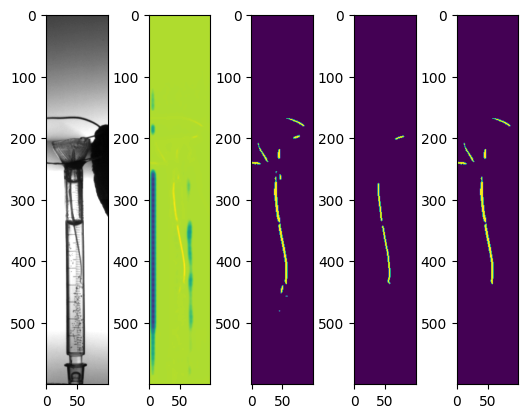

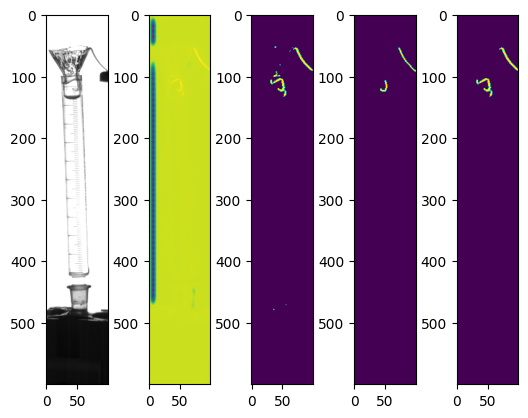

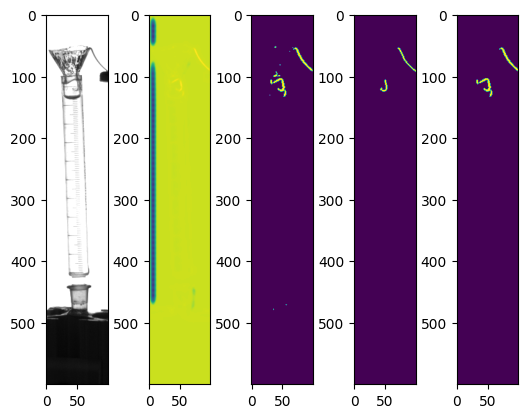

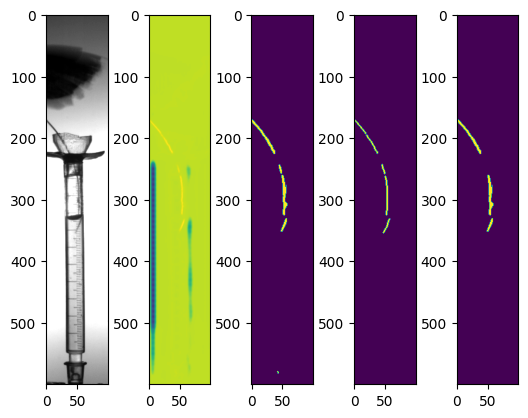

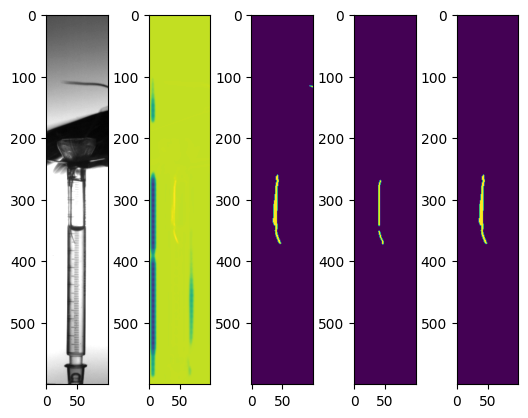

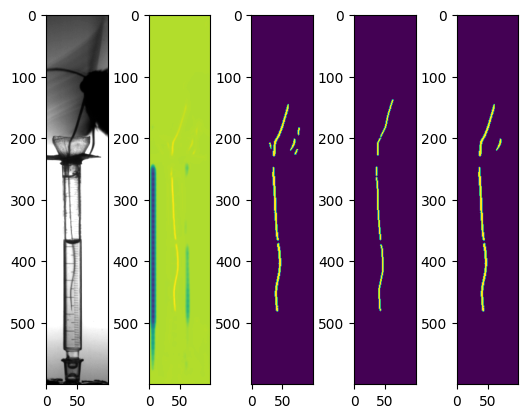

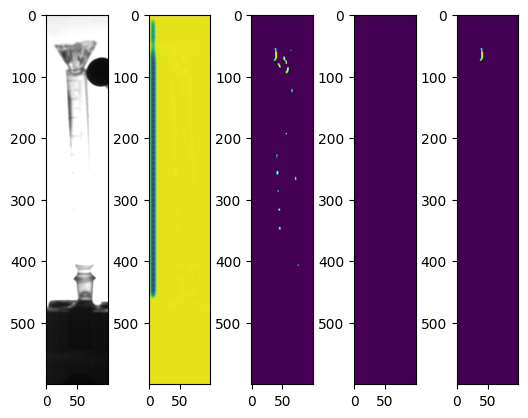

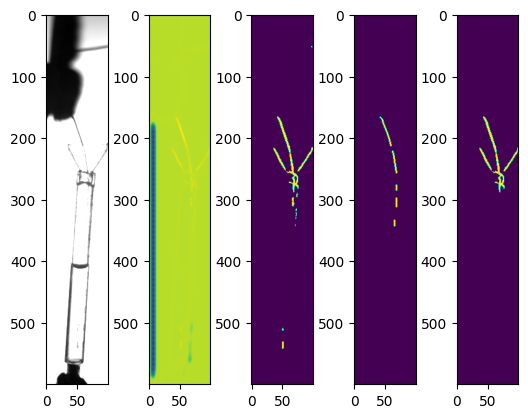

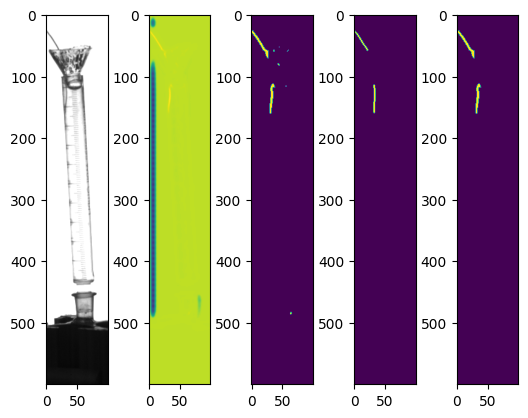

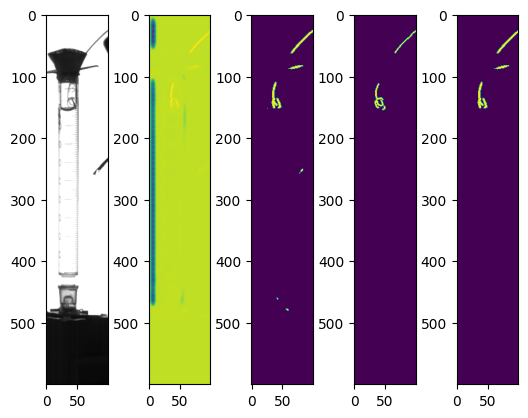

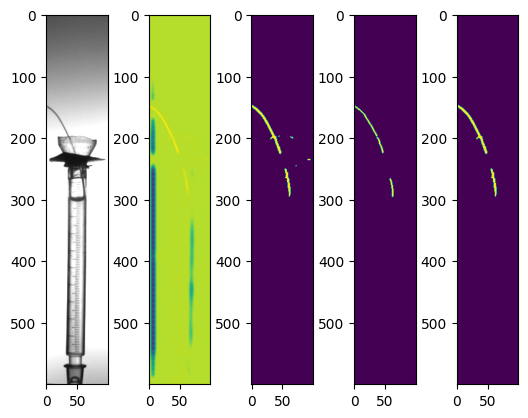

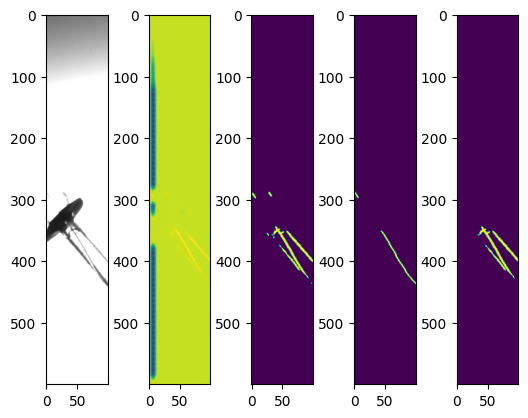

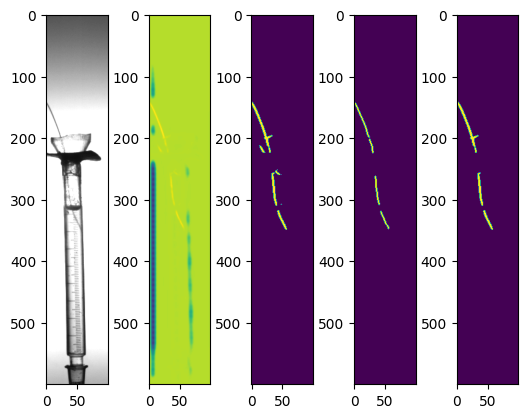

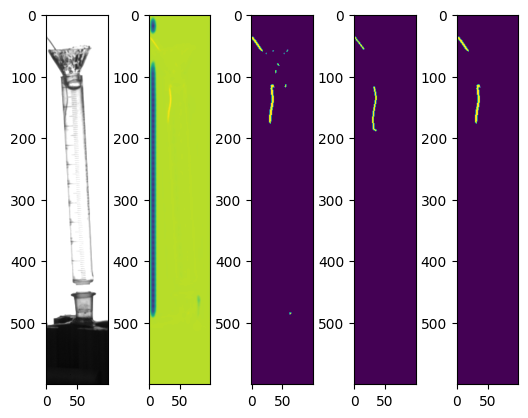

In [71]:
from skimage.morphology import remove_small_objects
unspeckle = np.empty_like(pred)
for i in range(16):
    mask = pred[i,:,:,0] > 0.1
    size_filt = remove_small_objects(mask, min_size=50, connectivity=2)
    unspeckle[i,:,:,0] = size_filt

for i in range(16):
    fig, (ax1, ax2, ax3, ax4, ax5) = pyplot.subplots(1,5)
    ax1.imshow(h_in[i,:,:,0], cmap='gray', vmin=0, vmax=255)
    ax2.imshow(pred[i,:,:,0])
    ax3.imshow(pred[i,:,:,0] > 0.1)
    ax4.imshow(h_out[i,:,:,0])
    ax5.imshow(unspeckle[i,:,:,0])
    fig.show()

In [37]:
def batch_remove_small(batch_array):
    out = np.empty_like(batch_array)
    for i in range(len(batch_array)):
        mask = batch_array[i,:,:,0] > 0.1
        size_filt = remove_small_objects(mask, min_size=50, connectivity=2)
        out[i,:,:,0] = size_filt
    return out

In [38]:
from skimage.measure import label, regionprops_table

In [46]:
known_pos = []
measured_pos = []
difs = []

for inbox, outbox in augmented:
    pred = model(inbox).numpy()
    above = pred > 0.1
    bigs = batch_remove_small(pred)
    for i in range(len(inbox)):
        known_label = label(outbox[i,:,:,0])
        measure_label = label(bigs[i,:,:,0])
        known_table = regionprops_table(known_label, 
                                        pred[i,:,:,0], 
                                        properties=('label','bbox', 'feret_diameter_max'))
        measure_table = regionprops_table(measure_label, 
                                          pred[i,:,:,0], 
                                          properties=('label','bbox','feret_diameter_max'))
        known = max(known_table['bbox-2'], default=-10)
        measured = max(measure_table['bbox-2'], default=-10)
        dif = known - measured
        
        known_pos.append(known)
        measured_pos.append(measured)
        difs.append(dif)

(array([1.30e+01, 2.00e+00, 4.00e+00, 9.00e+00, 8.00e+00, 7.00e+00,
        2.00e+01, 2.10e+01, 1.80e+01, 1.50e+01, 9.00e+00, 1.50e+01,
        1.40e+01, 3.20e+01, 1.50e+01, 7.50e+01, 6.20e+01, 6.00e+01,
        3.40e+01, 1.31e+02, 8.10e+01, 6.10e+01, 1.65e+02, 9.60e+01,
        2.46e+02, 1.58e+02, 5.14e+02, 9.66e+02, 9.41e+03, 5.33e+02,
        2.58e+02, 1.27e+02, 5.70e+01, 8.00e+01, 1.00e+00, 2.00e+01,
        2.19e+02, 1.30e+01, 5.00e+00, 3.00e+00, 3.00e+00, 2.00e+00,
        1.00e+00, 0.00e+00, 1.00e+01, 0.00e+00, 0.00e+00, 2.00e+00,
        3.00e+00, 2.00e+00]),
 array([-610. , -588.4, -566.8, -545.2, -523.6, -502. , -480.4, -458.8,
        -437.2, -415.6, -394. , -372.4, -350.8, -329.2, -307.6, -286. ,
        -264.4, -242.8, -221.2, -199.6, -178. , -156.4, -134.8, -113.2,
         -91.6,  -70. ,  -48.4,  -26.8,   -5.2,   16.4,   38. ,   59.6,
          81.2,  102.8,  124.4,  146. ,  167.6,  189.2,  210.8,  232.4,
         254. ,  275.6,  297.2,  318.8,  340.4,  362. ,  383.6,  4

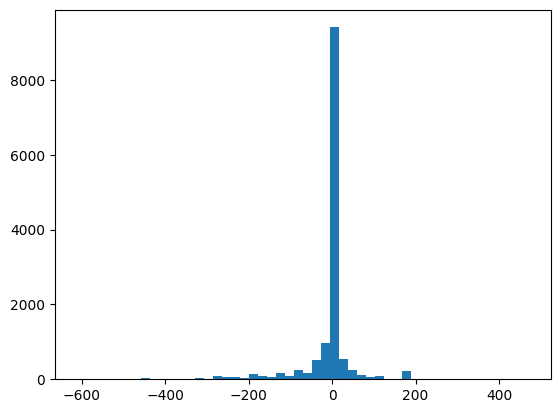

In [65]:
pyplot.hist(difs, bins=50)

(array([3.6000e+01, 8.1000e+01, 8.5000e+01, 3.6200e+02, 6.4900e+02,
        1.1581e+04, 5.2300e+02, 2.6000e+02, 1.6000e+01, 7.0000e+00]),
 array([-610., -502., -394., -286., -178.,  -70.,   38.,  146.,  254.,
         362.,  470.]),
 <BarContainer object of 10 artists>)

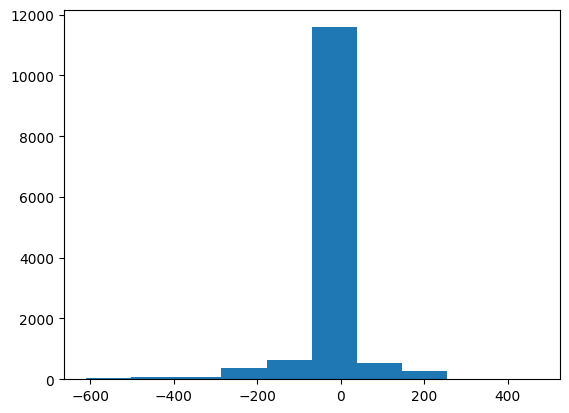

In [66]:
pyplot.hist(difs)

-11

76.41334961902926